#Import the necessary packages

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from transformers import TFAutoModel, BertTokenizer

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [ ]:
import typing
from typing import List, Tuple
import tiktoken
import ast
import time

In [ ]:
def read_list_from_file(file_path):
    try:
        with open(file_path, 'r') as file:
            # Read the file content as a string
            file_content_str = file.read()

            # Safely evaluate the string as a Python literal (list)
            file_contents = ast.literal_eval(file_content_str)

        return file_contents

    except FileNotFoundError:
        print(f"The file '{file_path}' does not exist.")
    except (SyntaxError, ValueError) as e:
        print(f"Error while evaluating the file content: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

def df_from_file(file_path):
    listy = read_list_from_file(file_path)
    category = file_path.replace(".txt", "")
    df = pd.DataFrame({'response': listy, 'category': [category] * len(listy)})
    return df

#Files is a list of files to add it from. Put it all in one dataframe
def multiple_df(files):
    dfs = []
    for file in files:
        dfs.append(df_from_file(file))

    result_df = pd.concat(dfs, ignore_index=True)
    return result_df


ret = multiple_df(["AC.txt", "PC.txt", "TC.txt", "NC.txt"])
shuffled_df = ret.sample(frac=1).reset_index(drop=True)
shuffled_df

,response,category
0,One of the in person exams is on my school's s...,AC
1,I don‚Äôt really have any concerns aside from ...,NC
2,I don't have any worries.,NC
3,I believe all that would come up is just coord...,TC
4,Im concerned I won't time manage.,NC
...,...,...
7421,The thing that most concerns me is the exam da...,PC
7422,I think multivariable calculus will be a more ...,AC
7423,Some concerns may have might be more technical...,AC
7424,No fundamental practice after watching videos,NC


In [ ]:
#Loads my tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Loads my data frame
df = shuffled_df

#Puts my data frame in a good format for ML
#Max length is 512
#encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
#labels = torch.tensor(df['category'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
shuffled_df

# Define a mapping dictionary
category_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}

# Apply the mapping using the map function
shuffled_df['category_int'] = df['category'].map(category_mapping)
shuffled_df

,response,category,category_int
0,One of the in person exams is on my school's s...,AC,0
1,I don‚Äôt really have any concerns aside from ...,NC,3
2,I don't have any worries.,NC,3
3,I believe all that would come up is just coord...,TC,2
4,Im concerned I won't time manage.,NC,3
...,...,...,...
7421,The thing that most concerns me is the exam da...,PC,1
7422,I think multivariable calculus will be a more ...,AC,0
7423,Some concerns may have might be more technical...,AC,0
7424,No fundamental practice after watching videos,NC,3


In [ ]:
# Load your DataFrame
df = shuffled_df

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')  # Reduced max_length for speed
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category_int'].unique()))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Average Epoch Loss: {avg_epoch_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 372/372 [02:09<00:00,  2.87it/s]


Average Epoch Loss: 0.7765
Epoch 2/5


100%|██████████| 372/372 [02:10<00:00,  2.86it/s]


Average Epoch Loss: 0.6269
Epoch 3/5


100%|██████████| 372/372 [02:09<00:00,  2.87it/s]


Average Epoch Loss: 0.5797
Epoch 4/5


100%|██████████| 372/372 [02:09<00:00,  2.87it/s]


Average Epoch Loss: 0.5512
Epoch 5/5


100%|██████████| 372/372 [02:09<00:00,  2.87it/s]

Average Epoch Loss: 0.5306


In [ ]:
# Evaluation loop (optional)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(input_ids=inputs)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Save the model to a file
torch.save(model.state_dict(), 'bert_model.pth')

# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
loaded_model.load_state_dict(torch.load('bert_model.pth'))
loaded_model.eval()  # Set the model to evaluation model

In [ ]:
import torch
from torch.nn.functional import softmax

# Example text for evaluation
text = "I'm concerned about not remembering stuff from calc"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move inputs to the same device as the model (assuming model is on cuda:0)
inputs = {k: v.to("cuda:0") for k, v in inputs.items()}

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities (you may need to adjust this based on your specific task)
probs = softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probs, dim=1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs.tolist()}")


## Modification using Tensorboard - Visualization

Epoch 1/5


100%|██████████| 165/165 [00:55<00:00,  2.98it/s]

Average Train Loss: 0.0530


Average Test Loss: 0.6845
Test Accuracy: 0.8176
Epoch 2/5


100%|██████████| 165/165 [00:56<00:00,  2.90it/s]

Average Train Loss: 0.0760


Average Test Loss: 0.6701
Test Accuracy: 0.8313
Epoch 3/5


100%|██████████| 165/165 [00:57<00:00,  2.88it/s]

Average Train Loss: 0.0368


Average Test Loss: 0.6817
Test Accuracy: 0.8343
Epoch 4/5


100%|██████████| 165/165 [00:57<00:00,  2.88it/s]

Average Train Loss: 0.0128


Average Test Loss: 0.7993
Test Accuracy: 0.8298
Epoch 5/5


100%|██████████| 165/165 [00:56<00:00,  2.90it/s]

Average Train Loss: 0.0161


Average Test Loss: 0.7665
Test Accuracy: 0.8343


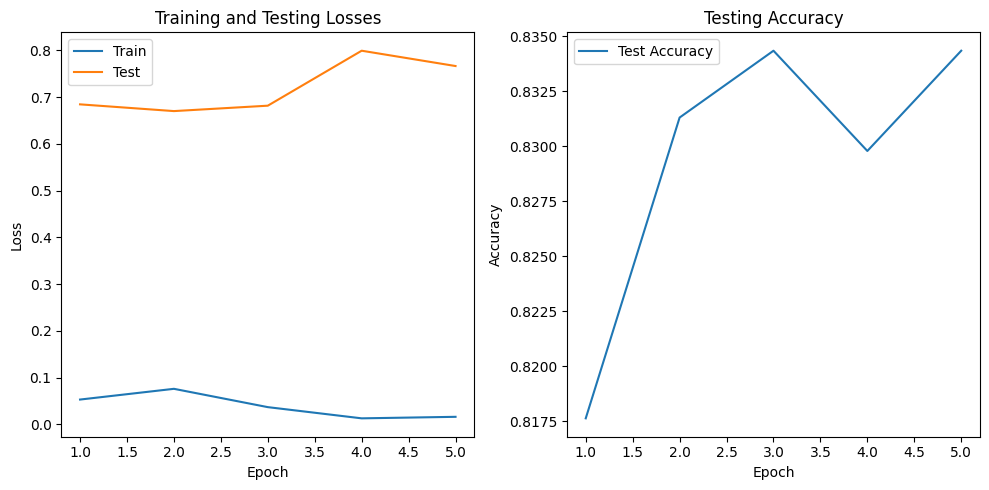

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 5
# Lists to store training and testing metrics
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0
    model.train()
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    model.eval()
    epoch_test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(input_ids=inputs)
            loss = criterion(outputs.logits, labels)
            epoch_test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_test_loss = epoch_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting the training and testing curves
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
